<a href="https://colab.research.google.com/github/wzkwds/SIM/blob/main/sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

torch.Size([400, 3])
torch.Size([40, 3])
Epoch [50/2000], Training Loss: 0.000595
Epoch [100/2000], Testing Loss: 0.008053
Epoch [100/2000], Testing Loss: 0.738583
Epoch [100/2000], Testing Loss: 0.676907
Epoch [100/2000], Testing Loss: 0.249459
Epoch [100/2000], Training Loss: 0.000002
Epoch [150/2000], Testing Loss: 0.008307
Epoch [150/2000], Testing Loss: 0.732284
Epoch [150/2000], Testing Loss: 0.677875
Epoch [150/2000], Testing Loss: 0.247367
Epoch [150/2000], Training Loss: 0.000001
Epoch [200/2000], Testing Loss: 0.008266
Epoch [200/2000], Testing Loss: 0.737638
Epoch [200/2000], Testing Loss: 0.687441
Epoch [200/2000], Testing Loss: 0.253270
Epoch [200/2000], Training Loss: 0.000001
Epoch [250/2000], Testing Loss: 0.008209
Epoch [250/2000], Testing Loss: 0.734935
Epoch [250/2000], Testing Loss: 0.692577
Epoch [250/2000], Testing Loss: 0.255822
Epoch [250/2000], Training Loss: 0.000001
Epoch [300/2000], Testing Loss: 0.008138
Epoch [300/2000], Testing Loss: 0.732412
Epoch [300/2

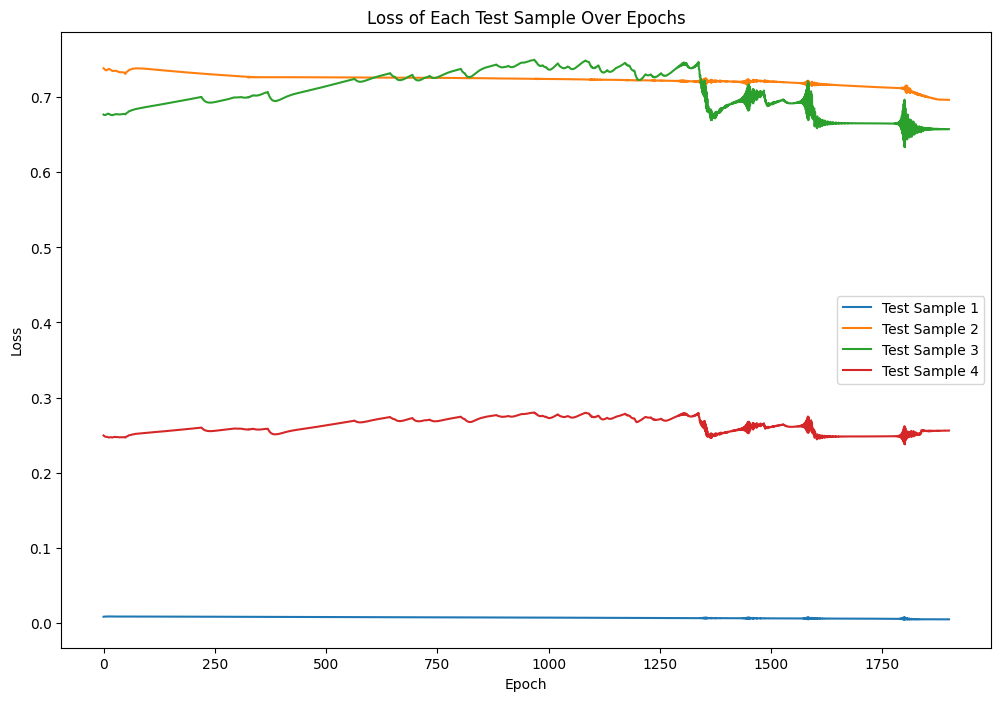

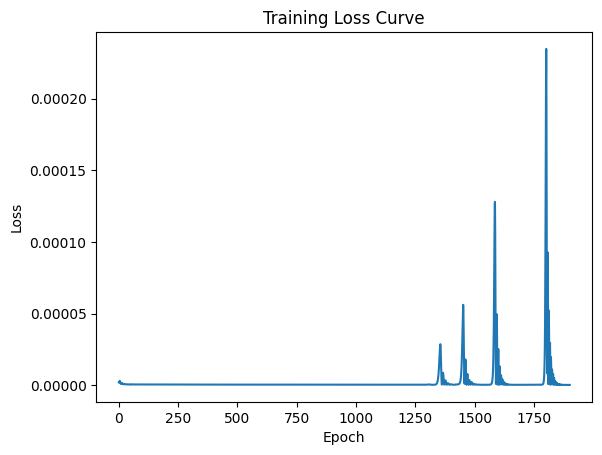


Train Loss: 0.000000
Test Loss: 0.006122

Test results:
Input: tensor([9.9537e-01, 4.6037e-04, 1.0044e+00]), Predicted: tensor([ 0.9719, -0.0569,  0.9087])
Input: tensor([ 0.9899,  0.9945, -0.0045]), Predicted: tensor([ 0.9358,  0.9206, -0.1036])
Input: tensor([0.0041, 0.9965, 1.0019]), Predicted: tensor([-0.0137,  0.9634,  0.8957])
Input: tensor([0.9954, 0.9959, 1.0069]), Predicted: tensor([0.9800, 0.8653, 0.8990])


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# success_mode
means = torch.tensor([
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 1.0],
    [0.0, 1.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 1.0],
    [1.0, 1.0, 0.0],
    [0.0, 1.0, 1.0],
    [1.0, 1.0, 1.0]
])

# # failure_mode(still fail?)
# means = torch.tensor([
#     [0.0, 0.0, 0.0],
#     [1.0, 0.0, 0.0],
#     [0.0, 1.0, 0.0],
#     [1.0, 1.0, 1.0],
#     [0.0, 0.0, 1.0],
#     [0.0, 1.0, 1.0],
#     [1.0, 0.0, 1.0],
#     [1.0, 1.0, 0.0]
# ])

# # test_mode
# means = torch.tensor([
#     [1.0, 0.0, 0.0],
#     [0.0, 1.0, 0.0],
#     [0.0, 0.0, 1.0],
#     [1.0, 1.0, 1.0],
#     [0.0, 0.0, 0.0],
#     [0.0, 1.0, 1.0],
#     [1.0, 0.0, 1.0],
#     [1.0, 1.0, 0.0]
# ])


# # test_mode
# means = torch.tensor([
#     [0.0, 0.0, 0.0],
#     [3.0, 0.0, 0.0],
#     [0.0, 1.7, 0.0],
#     [0.0, 1.0, 0.7],
#     [3.0, 1.7, 0.0],
#     [3.0, 0.0, 0.7],
#     [0.0, 1.7, 0.7],
#     [3.0, 1.7, 0.7]
# ])

std_dev = 0.005
train_num_clusters = 100
test_num_clusters = 10

# 生成训练数据（前4个均值）
train_data_points = []
for i in range(4):
  for _ in range(train_num_clusters):
    point = torch.normal(mean=means[i], std=std_dev)
    train_data_points.append(point)

# 生成测试数据（后4个均值）
test_data_points = []
for i in range(4, 8):
  for _ in range(test_num_clusters):
    point = torch.normal(mean=means[i], std=std_dev)
    test_data_points.append(point)

train_data_points = torch.stack(train_data_points)
print(train_data_points.shape)
test_data_points = torch.stack(test_data_points)
print(test_data_points.shape)

test_loss_points = means[4:8]

# 标签等于输入点
train_labels = train_data_points.clone()
test_labels = test_data_points.clone()
test_loss_labels = test_loss_points.clone()

# 单隐藏层MLP
class MLP(nn.Module):
    def __init__(self,std_rate=0.5):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(3, 128)
        self.fc2 = nn.Linear(128, 3)

        self._initialize_weights(std_rate)

    def _initialize_weights(self, std_rate):
      for m in self.modules():
        if isinstance(m, (nn.Linear)):
          fan_in, _ = nn.init._calculate_fan_in_and_fan_out(
              m.weight)
          nn.init.normal_(m.weight, 0, 1 /
                    fan_in ** (std_rate))
          if m.bias is not None:
            nn.init.normal_(m.bias, 0, 1 /
                    fan_in ** (std_rate))

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

std_rate = 2.0
lr = 0.01
model = MLP(std_rate=std_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# 记录每个epoch的损失值
loss_history = []

test_loss_history = [[] for _ in range(4)]

# 训练模型
num_epochs = 2000
for epoch in range(num_epochs):
    outputs = model(train_data_points)
    loss = criterion(outputs, train_labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >= 99:
      loss_history.append(loss.item())

      with torch.no_grad():
        test_outputs = model(test_loss_points)
        for i in range(4):
            sample_loss = criterion(
                test_outputs[i], test_labels[i])

            if (epoch + 1) % 50 == 0:
              print(f'Epoch [{epoch + 1}/{num_epochs}], Testing Loss: {sample_loss.item():.6f}')

            test_loss_history[i].append(sample_loss.item())

    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss.item():.6f}')

plt.figure(figsize=(12, 8))
for i in range(4):
    plt.plot(test_loss_history[i], label=f'Test Sample {i + 1}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss of Each Test Sample Over Epochs')
plt.legend()
plt.show()

# 绘制损失变化图
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

# 测试模型
with torch.no_grad():
    # 训练数据上的预测
    train_outputs = model(train_data_points)
    train_loss = criterion(train_outputs, train_labels)

    # 测试数据上的预测
    test_outputs = model(test_data_points)
    test_loss = criterion(test_outputs, test_labels)

    # 打印训练和测试误差
    print(f"\nTrain Loss: {train_loss.item():.6f}")
    print(f"Test Loss: {test_loss.item():.6f}")

    # # 打印训练和测试结果
    # print("\nTrain results:")
    # for i in range(train_data_points.shape[0]):
    #     print(f"Input: {train_data_points[i]}, Predicted: {train_outputs[i]}")

    print("\nTest results:")
    for i in range(0, test_data_points.shape[0], test_num_clusters):
        print(f"Input: {test_data_points[i]}, Predicted: {test_outputs[i]}")